<a id = 'home'></a>

# Predicting Sale Price for the Ames Housing Data

This notebook walks through my approach to creating a model to predict the sale price for residential properties in Ames, Iowa from 2006 to 2010.  A key challenge to using this dataset is the number of features and messiness of the data.  In total, there are 82 features of which 23 are nominal, 23 are ordinal, 14 discrete, and 20 continuous (2 more are identifiers).

---
[Data Dictionary](https://ww2.amstat.org/publications/jse/v19n3/decock/datadocumentation.txt)


<a id = 'toc'></a>

## Table of Contents

- [Project Home](#home)
- [Library Imports](#imports)
- [Exploratory Data Analysis](#eda)
    - [Evaluating Shape and Missingness](#data)
    - [Cleaning the Data](#cleaning)
- [Train-Test Split](#tts)
- [Establishing the Baseline](#baseline)
- [Regession Models](#models)
    - [Linear Model](#lm)
    - [Lasso](#lasso)
    - [Recursive Feature Elimination](#rfe)
    - [Linear Bagging](#lb)
    - [Ada Boost](#ada-boost)
    - [Gradient Boost](#grade-boost)
- [Evaluating the Best Model](#evaluation)
- [Conclusions](#conclusions)


<a id = 'imports'></a>
## Library Imports


In [85]:
# data libraries
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import RFE
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor

# processing
from sklearn.preprocessing import StandardScaler, LabelBinarizer, Imputer

#plotting customizations
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')

<a id = 'data'></a>
## Import the Data

In [58]:
df = pd.read_csv("train.csv")

<a id = 'eda'></a>

## Exploratory Data Analysis

[Home](#home)

<a id = 'data'></a>
### Evaluating Shape and Missingness

In [59]:
df.shape

(2051, 82)

In [60]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 82 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

A quick look at the column names shows that there's whitespace in the names.  To make things easier, I'm gong to strip out the whitespace from the column names.

In [61]:
df.columns = df.columns.str.replace('\s+', '')

Missingness looks like a real problems but I want to quantify exaclty how bad.

In [62]:
df.isnull().sum().sum()

9822

It's pretty bad! The data is going to need a lot of cleaning.

<a id = 'cleaning'></a>
### Cleaning the Data

[Home](#home)

There's a lot of features that have very little variation and have lots of missing values.  I'm going to drop these.  I'm also dropping the `PID` variable since it is an individual identifier.

In [63]:
# create a list of the features to drop
drop_columns = ['PoolQC',
               'Fence',
               'MiscFeature',
               'Street',
               'Utilities',
               'LandSlope',
               'Condition2',
               'RoofStyle',
               'RoofMatl',
               'Exterior2nd',
               'MasVnrType',
               'BsmtExposure',
               'BsmtFinType2',
               'Heating',
               'SaleType',
               'GarageYrBlt',
               'PID']

# drop the features from the drop list
df.drop(drop_columns, axis=1, inplace=True)

#### Categorical Variables
As noted at the start of this project, many variables are categorical variables.  Rather than repeating the same code again and again to convert these features into a series of dichotomous variables, I wrote a function to do it for me.  One key feature of the function is that it does not automatically drop the original feature once it's been converted, necessitating manually dropping the column.

In [64]:
# create a function that does labelbinarization and assigns column names to feature categories
def labelizer(feature, dataframe):
    """
    Input is a feature, passed as a string, that you wish to make into multiple binary variables and the dataframe it lives in.
    Recommended for use in turning categorical string variables into dummy variables.
    Output is the input dataframe with n number of new columns where n is the number of categories in the feature input.
    If output looks correct, save the function as either a new dataframe or overwrite the exisiting dataframe.
    """
    # first instantiate the encoder
    lb = LabelBinarizer()

    # fit and transform the feature
    new_feature = lb.fit_transform(dataframe[feature])

    # now need to assign column names to the new columns
    new_features = pd.DataFrame(new_feature, columns = ["_".join([feature, x]) for x in lb.classes_])
    
    #now join it with the dataframe
    return pd.concat([dataframe.reset_index(drop=True),new_features.reset_index(drop=True)], axis=1)

In [65]:
# Using the labelizer function

#fill in NaNs
df['MSZoning'].fillna(value = 'missing', inplace = True)
#call the function and save the returned features from the function to the df
df = labelizer('MSZoning', df)

df['Neighborhood'].fillna(value = 'missing', inplace = True)
df = labelizer('Neighborhood', df)

df['Condition1'].fillna(value = 'missing', inplace = True)
df = labelizer('Condition1', df)

df['BldgType'].fillna(value = 'missing', inplace = True)
df = labelizer('BldgType', df)

df['Exterior1st'].fillna(value = 'missing', inplace = True)
df = labelizer('Exterior1st', df)

df['Foundation'].fillna(value = 'missing', inplace = True)
df = labelizer('Foundation', df)

df['GarageType'].fillna(value = 'NoGar', inplace = True)
df = labelizer('GarageType', df)

df['PavedDrive'].fillna(value = 'missing', inplace = True)
df = labelizer('PavedDrive', df)

# dropping the labelized features
labelized_columns = ['MSZoning',
                     'Neighborhood',
                     'Condition1',
                     'BldgType',
                     'Exterior1st',
                     'Foundation',
                     'GarageType',
                     'PavedDrive']

df.drop(labelized_columns, axis=1, inplace=True)

According to the Ames housing data dictionary, for the quality and condition variables, missing does not mean missing but rather that the item is absent from the home. To handle these ordinal quality variables, I created a function to apply the following mapping for the feature.

|Value|Meaning|New Value|
|---|---|---|
|Ex|excellent|5|
|Gd |good|4|
|TA |average|3|
|Fa|fair| 2|
|Po|poor|1|
|NaN|none|0|

In [66]:
# create a function that recodes quality variables according to a quality dictionary
def qualitizer(feature, dataframe):
    """
    Input is a feature, passed as a string, that you wish to make into an ordinal quality variable and the dataframe it lives in.
    Recommended for use in turning ordinal string variables into numerical values.
    Output is the input dataframe with the feature recoded.
    'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1, 'NaN':0
    """
    # the quality dictionary:
    quality = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}
    # recode the variable into a new variable
    dataframe[feature] = dataframe[feature].map(quality)
    # fill NaNs as 0
    dataframe[feature].fillna(value=0, inplace = True)

In [67]:
# Using the qualitizer function

qualitizer('FireplaceQu',df)

qualitizer('ExterQual', df)

qualitizer('ExterCond', df)

qualitizer('BsmtQual', df)

qualitizer('BsmtCond', df)

qualitizer('HeatingQC', df)

qualitizer('KitchenQual', df)

qualitizer('GarageQual',df)

qualitizer('GarageCond', df)

Many variables have categorical variables that have one meaningful category and can be recoded into dichotmous variables. I use lambda functions to recode features into usable variables.

In [68]:
# Recodes
df['Alley'] = df['Alley'].apply(lambda x: 1 if x in ['Grvl','Pave'] else 0)

df['LotShape'] = df['LotShape'].apply(lambda x: 0 if x == 'Reg' else 1)

df['LandContour'] = df['LandContour'].apply(lambda x: 0 if x == 'Lvl' else 1)

df['LotConfig'] = df['LotConfig'].apply(lambda x: 0 if x == 'Inside' else 1)

df['HouseStyle'] = df['HouseStyle'].apply(lambda x: 0 if x == '1Story' else 1)

df['BsmtFinType1'] = df['BsmtFinType1'].map({'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'unf':1})
df['BsmtFinType1'].fillna(value=0, inplace = True)

df['CentralAir'] = df['CentralAir'].apply(lambda x: 1 if x == 'Y' else 0)

df['Electrical'] = df['Electrical'].map({'SBrkr':5,'FuseA':4,'FuseF':3,'FuseP':2,'Mix':1})
df['Electrical'].fillna(value=0, inplace = True)

df['Functional'] = df['Functional'].apply(lambda x: 0 if x == 'Typ' else 1)

df['GarageFinish'] = df['GarageFinish'].map({'Fin':3,'RFin':2,'Unf':1})
df['GarageFinish'].fillna(value=0, inplace = True)

There are still a handful of missing values in the remaining features.  I use a an imputer to handle two columns with values that subjectively make sense and then fill in the rest of the data with zeros.

In [69]:
# imputed values

median_imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
df['LotFrontage'] = median_imputer.fit_transform(df[['LotFrontage']]).ravel()

modal_imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
df['MasVnrArea'] = modal_imputer.fit_transform(df[['MasVnrArea']]).ravel()

df.fillna(value = 0,inplace=True)

In [71]:
# Confirm that there aren't any nulls left in the data
df.isnull().sum().sum()

0

The data are now clean and ready for modeling.

<a id = 'tts'></a>

## Train-Test Split

[Home](#home)

To improve model generalizability, I'm going to perform a train-test split to create a hold-out set for my data to test the model against.

In [75]:
# features are all remaining columns that are not one of the two potential targets `SalePrice` or 'SalesCondition`
drop_cols = ['SalePrice',
             'SaleCondition']
X = df.drop(drop_cols, axis=1)

#scale the feature dataset
ss = StandardScaler()
Xss = ss.fit_transform(X)

# set target 1 as the sale price
target = df['SalePrice'].copy()

# Do the TTS
X_train,X_test, y_train, y_test = train_test_split(Xss, target, random_state = 13, test_size=.33)

<a id = 'baseline'></a>

## Establishing the Baseline

[Home](#home)

For regression, the baseline $R^2$ is going to be 0 for the training set. In this section, I show that explicitly by using the mean of `SalePrice` as the regressor.

In [78]:
#generate a list of estimates the length of the y_train_reg dataset
lst = [np.mean(y_train)] * len(y_train)

#generate a df made up of y and y_hat (which is y_bar in this case)
ys = pd.DataFrame({'Y': y_train, 'Y_hat': lst})

# get the r^2
y_bar = ys['Y'].mean()

ss_tot = np.square(ys['Y'] - y_bar).sum()
ss_res = np.square(ys['Y'] - ys['Y_hat']).sum()

r_2 = 1 - (ss_res/ss_tot)
print('The R^2 is',r_2)

The R^2 is 0.0


<a id = 'models'></a>

## Regression Models

[Home](#home)

<a id= 'lm'></a>
#### Linear Model

With the baseline expectation established, I start with the most basic model, a linear regression.

In [81]:
# instantiate the model
lr = LinearRegression()

# score the model with cross validation
lr_model_scores = cross_val_score(lr, X_train, y_train, cv = 5)

# print the results
print('The linear model R^2 mean is: {0:.4g}'.format(lr_model_scores.mean()))

The linear model R^2 mean is: -1.279e+21


This model doesn't perform well at all.

<a id = 'lasso'></a>
#### Lasso with Grid Search

This model will use L1 regularization to try and make better use of the features. I use GridSearchCV to perform multiple model fits to optimize the model.  This model takes approximately 40 seconds to run.

In [86]:
# instantiate the regression
lasso = Lasso(normalize=False)

# create a paramter dictionary of different alpha values
lasso_params = {'alpha':np.linspace(.1,10,100)}

# call the grid search on the model
grid_lasso = GridSearchCV(lasso, lasso_params, cv = 5, verbose = 1, n_jobs = -1)

# fit the model on the data
grid_lasso.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceW

/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceW

/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceW

/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceW

/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceW

/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceW

/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceW

/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/DavidAGelman/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceW

The best lasso score is: 0.852157336279419
The best lasso model is: Lasso(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   41.4s finished


In [100]:
# print search results
print('The average lasso score is: {}'.format(grid_lasso.cv_results_['mean_test_score'].mean()))
print('The best lasso score is: {}'.format(grid_lasso.best_score_))
print('The best lasso model is: {}'.format(grid_lasso.best_estimator_))

The average lasso score is: 0.8518247684217702
The best lasso score is: 0.852157336279419
The best lasso model is: Lasso(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


<a id = 'rfe'></a>
#### Recursive Feature Elimination (RFE)

In [104]:
# create the estimator objects
lr = LinearRegression()

#take half the feautres available
rfe = RFE(lr, n_features_to_select=(len(X)/2), verbose=2)

# cross validate the  RFE
mod_rfe = cross_val_score(rfe, X_train, y_train, cv = 5)

# print the results
print('The rfe model R^2 mean is: {0:.4g}'.format(mod_rfe.mean()))

The rfe model R^2 mean is: -6.967e+20


The model still isn't performing very well!

<a id = 'lb'></a>
#### Linear Bagging

Since the lasso model was the best model so far, I'm going to use that as my estimator inside of a boostrap aggregator.

In [107]:
# from the grid search, the following model is the best lasso
best_lasso = Lasso(alpha=10, normalize=False, max_iter = 3000)

# create the bagger
bagging = BaggingRegressor(base_estimator = best_lasso, max_samples=0.5, max_features=0.5)

# cross validate the bagger
lasso_bagger = cross_val_score(bagging, X_train, y_train, cv=5, n_jobs=-1, verbose = 1)
                              
# print the results
print('The average bagged lasso R^2 is: {0:.4g}'.format(lasso_bagger.mean()))

The bagged lasso R^2 is: 0.852


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


This still isn't any better.  Time to go to boosting.

<a id = 'ada-boost'></a>
#### Ada Boost

In [109]:
# create the ada booster
ada_boost = AdaBoostRegressor(n_estimators = 70, random_state=1313)

# cross validate the ada booster
ada_boost = cross_val_score(ada_boost, X_train, y_train, cv=5, n_jobs=-1, verbose = 1)

# print the results
print('The average Ada Boost model R^2 is: {0:.4g}'.format(ada_boost.mean()))

The average Ada Boost model R^2 is: 0.8118


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Still no improvement.  Going to try one more...

<a id = 'grade-boost'></a>
#### Gradient Boosting

In [110]:
# create the gradient booster
grade_boost = GradientBoostingRegressor(n_estimators = 50, learning_rate = .1,random_state=1313)

# cross validate the booster
grade_boost = cross_val_score(grade_boost, X_train, y_train, cv=5, n_jobs=-1, verbose = 1)

# print the results
print('The average Gradient Boost model R^2 is: {0:.4g}'.format(grade_boost.mean()))

The average Gradient Boost model R^2 is: 0.8924


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


I've got a big jump in my $R^2$; gradient boosting looks like the way to go.  I'm going to try to see if I can up the performance just a little bit more.

In [116]:
# call in new gradient booster
grade_boost2 = GradientBoostingRegressor(n_estimators = 120, learning_rate = .1,random_state=1313)

# cross validate the new booster
grade_boost2_score = cross_val_score(grade_boost2, X_train, y_train, cv=5, n_jobs=-1, verbose = 1)

# print the results
print('The average Gradient Boost 2 model R^2 is: {0:.4g}'.format(grade_boost2_score.mean()))

The average Gradient Boost 2 model R^2 is: 0.8987


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


Ever-so-slightly better, but not meaningfully so.  A final option is to run the grid search below to try and optimize parameters.  However, I don't recomend doing so.  Run time for me was about two hours and 45 minutes and did not produce a model with noticeably better fit.

```
# create the parameter dictionary
boost_params = {'loss': ['ls', 'lad', 'huber', 'quantile'],
                      'n_estimators': range(90,140),
                      'max_depth': range(1,11),
                      'warm_start':[True,False]   
}

# create the gradient booster
grade_boost_gs = GradientBoostingRegressor(random_state=1313)

# create the grid search
grid_gradient_boost = GridSearchCV(grade_boost_gs, boost_params, cv = 5, verbose = 1, n_jobs = -1)

# fit the grid search
grid_gradient_boost.fit(X_train, y_train)

# print out the best score and the best model
print('The best grid gradient boost score is: {}'.format(grid_gradient_boost.best_score_))
print('The best grid gradient boost model is: {}'.format(grid_gradient_boost.best_estimator_))
```

<a id = 'evaluation'></a>
## Evaluating the Best Model
[Home](#home)

How does the best model (the second gradient boost) do against the hold out set? What do the predicted versus actual values look like? What are the most important features?

#### Model Performance With Test Data

In [117]:
# fit the model against the training data
grade_boost2.fit(X_train, y_train)

# print the results of the model for the training and test data
print('The R^2 of the model against the training data is: {}'.format(grade_boost2.score(X_train, y_train)))
print('The R^2 of the model against the test data is: {}'.format(grade_boost2.score(X_test, y_test)))


The R^2 of the model against the training data is: 0.9729568045066318
The R^2 of the model against the test data is: 0.9047839527017058


#### Plotting Predicted versus Actual Values

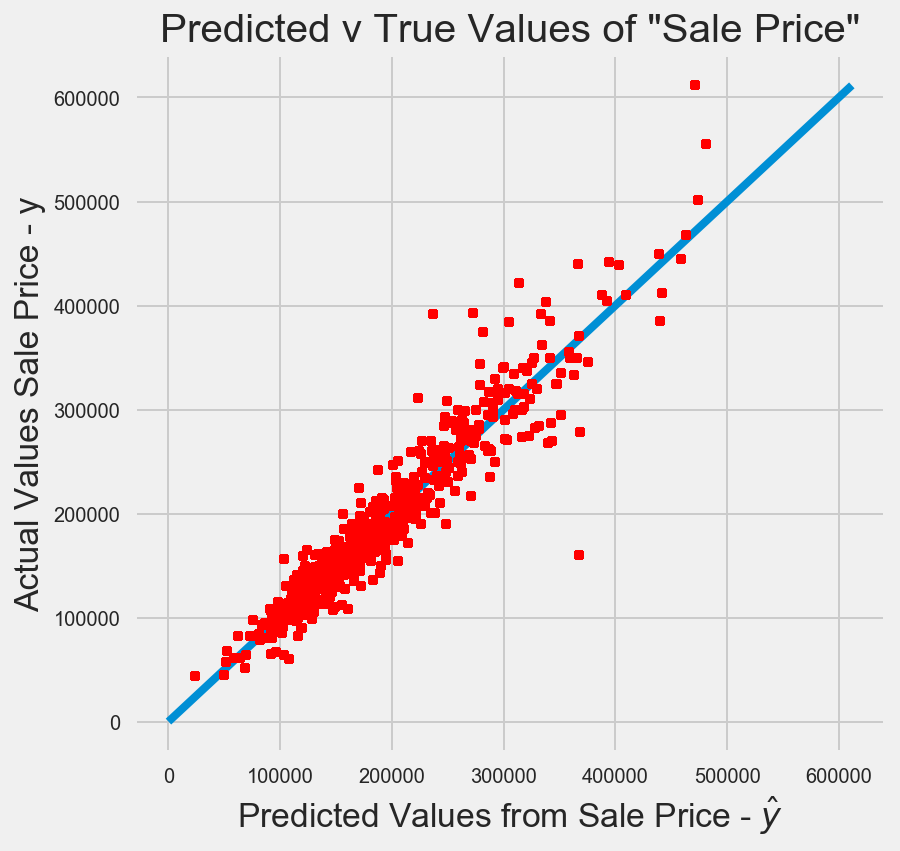

R^2 score:  0.904783952702


In [121]:
# make a plot of the predicted versus actual values and a regression line
predictions =  grade_boost2.predict(X_test)
score = grade_boost2.score(X_test, y_test)

# Plot the model
plt.figure(figsize=(6,6))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values from Sale Price - $\hat{y}$")
plt.ylabel("Actual Values Sale Price - y")
plt.title('Predicted v True Values of "Sale Price"')
plt.plot([0, np.max(y_test)], [0, np.max(y_test)])

plt.show()

print("R^2 score: ", score)

#### Plotting Feature Importance

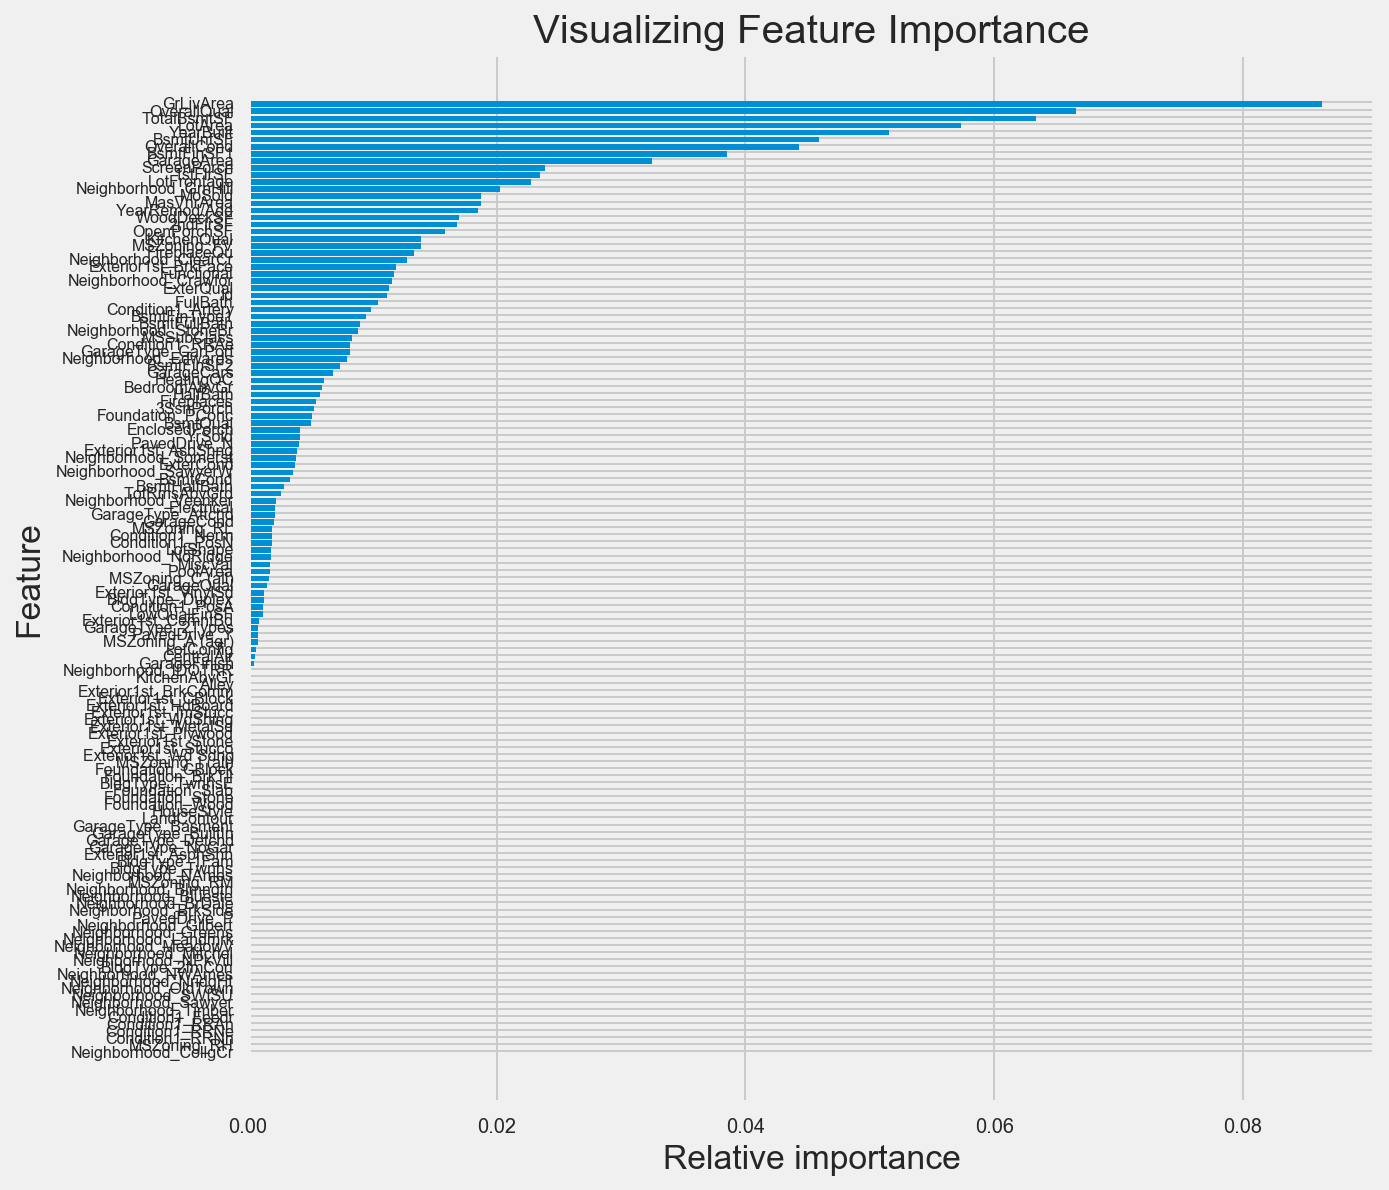

In [122]:
# grab column names
names = X.columns

# sort importances
indices = np.argsort(grade_boost2.feature_importances_)

# plot as bar chart
fig = plt.figure(figsize=(9, 9))
plt.barh(np.arange(len(names)), grade_boost2.feature_importances_[indices])
plt.yticks(np.arange(len(names)) + 0.25, np.array(names)[indices], size=8)
_ = plt.ylabel('Feature')
_ = plt.xlabel('Relative importance')
_ = plt.title('Visualizing Feature Importance')

In [123]:
# what are the important features
feature_import = pd.DataFrame(grade_boost2.feature_importances_, index = [X.columns])
feature_import.sort_values(by = 0,ascending=False)

,0
GrLivArea,0.086334
OverallQual,0.066600
TotalBsmtSF,0.063384
LotArea,0.057359
YearBuilt,0.051523
BsmtUnfSF,0.045918
OverallCond,0.044309
BsmtFinSF1,0.038552
GarageArea,0.032459
ScreenPorch,0.023890


#### Plotting Model Complexity versus Performance

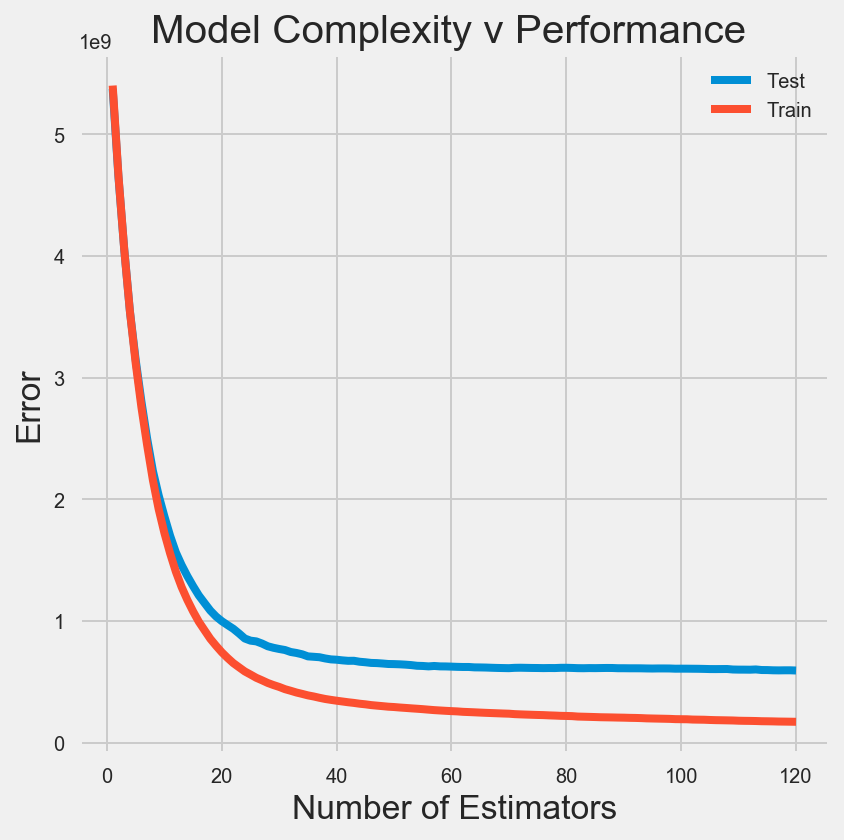

In [125]:
# plot complexity versus performance for train and test

test_score = np.empty(len(grade_boost2.estimators_))

for i, pred in enumerate(grade_boost2.staged_predict(X_test)):
    test_score[i] = grade_boost2.loss_(y_test, pred)

fig = plt.figure(figsize=(6, 6))
plt.plot(np.arange(grade_boost2.n_estimators) +1, test_score)
plt.plot(np.arange(grade_boost2.n_estimators) +1, grade_boost2.train_score_)
_ = plt.xlabel('Number of Estimators')
_ = plt.ylabel('Error')
_ = plt.title('Model Complexity v Performance ')
plt.legend(['Test', 'Train'])

<a id = 'conclusions'></a>
## Conclusions
[Home](#home)

As seen by the difference in model performance between the training and test (hold-out) data, the model does pretty well.  There's not a big dropoff in how much variances is explained by the model, suggesting the model isn't overfit.  Looking at the actual versus predicted values shows that the model does really well for sale prices up to \$300,000. Beyond that, the model breaks down a bit. However, since so much of the data is below that \$300,000 mark, perhaps this is alright and a better approach would be to create two models, one for low and average priced homes and a separate model for the top of the residential market.  From the chart of feature importance, it is quickly clear that only a few of the many features in the model are adding explantory power.  To refine the model and perhaps improve performance, I would drop many of the variables in the model.  This is confirmed by the final figure, plotting error reduction versus the number of model estimators.  There is a steep reduction in error with only 15 or so estimators.  While additional estimators do constribute to a further reduction in error, they do so only marginally.  